In [44]:
import os
import sys
current_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
import numpy as np              # Python's standard numerical library
import matplotlib.pyplot as plt # Python's scientific visualization library
from pyidi import ROISelect
from matplotlib.path import Path
import pickle as pk
from pixel_setter2 import PixelSetter#, play_video, detect_peaks
from pixel_setter import play_video
from scipy.ndimage import uniform_filter
from EMA_functions import *
from Feature_selecter import *
from DIC_functions import *
import glob
root_drive_sim = os.path.normpath('G:/.shortcut-targets-by-id/1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx/Illimited Lab Projects/Research Projects/Spiders/Simulations')
root_video = os.path.normpath('D:/thijsmas/wing')
root_mraw = os.path.normpath('D:/thijsmas/wing/mraw')
path_list = glob.glob(os.path.join(root_video, '*.cine'))

In [45]:
name_video =  '1xyz_a_rev6_wcam.cih'
root_video = r'D:\thijsmas\wing\mraw'
file_path = os.path.join(root_video, name_video)
DIC_structure = DIC_Structure(file_path)

df = DIC_structure.list_test_data(max_d = 20, max_dd = 1,  max_drift = 3, d_min=False, test_range = range(1,6), robostness_check = True)
df

Available filter methods: eig0, eig1, harris, trigs, harmonic_mean, eig_theta, eig_theta_off, eig0_test, eig1_test


,cih_file,test_number,createdate,method,roi_size,n_points,n_tracked_points,success_rate,dyx,smoothing_size
0,D:/thijsmas\wing\mraw\1xyz_a_rev6_wcam.cih,1,2024 03 22 18:27:06,lk,"[7, 7]",908,461,0.507709,None,None
1,D:/thijsmas\wing\mraw\1xyz_a_rev6_wcam.cih,2,2024 03 22 19:19:09,lk_1D,"[3, 3]",4184,1258,0.300669,None,None
2,D:/thijsmas\wing\mraw\1xyz_a_rev6_wcam.cih,3,2024 03 28 10:23:49,lk,"[7, 7]",813,393,0.483395,None,None
3,D:/thijsmas/wing/mraw\1xyz_a_rev6_wcam.cih,4,2024 04 03 16:50:08,lk,"[11, 11]",24,24,1.000000,None,None
4,D:/thijsmas\wing\mraw\1xyz_a_rev6_wcam.cih,5,2024 05 14 18:07:26,lk_1D,"[11, 11]",3200,2451,0.765938,"[1, 0]",None


In [46]:
file_name =  '1xyz_a_rev6_wcam.cine'
EMA_structure = EMA_Structure(file_name[:-5] + '.cih')
video = EMA_structure.open_video(add_extension=False)
video.info

bit_depth = video.info['EffectiveBit Depth']


D:/thijsmas\wing\mraw\1xyz_a_rev6_wcam.cih


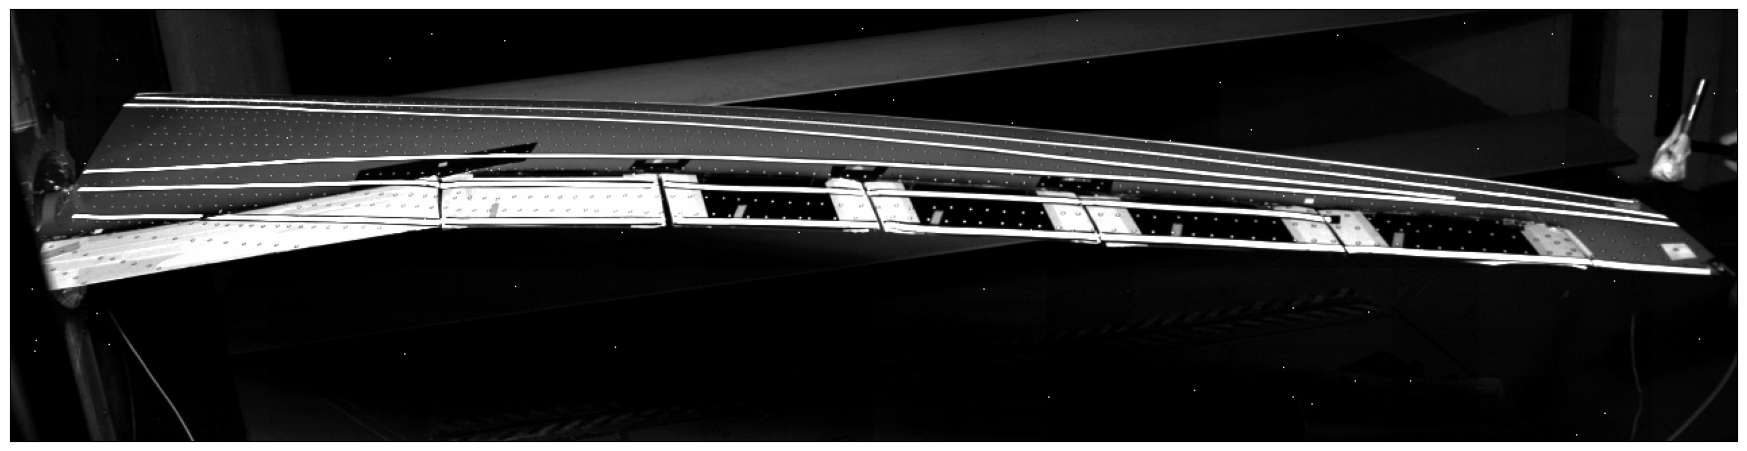

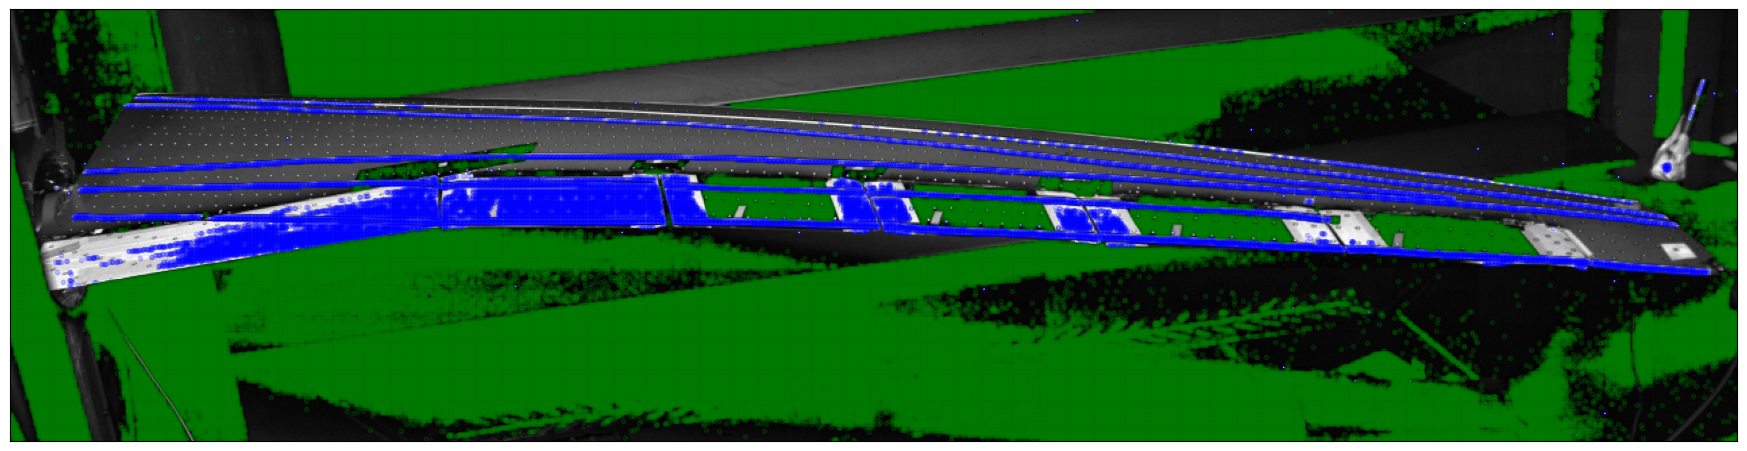

In [47]:
%matplotlib inline
sequential_image_n = 40
still_image = video.mraw[sequential_image_n]

fig, ax = EMA_structure.plot_still_frame(video, sequential_image_n, show_saturation=False, bit_depth = video.info['EffectiveBit Depth'])
# fig.savefig(os.path.join(root_drive_sim, 'still images', f'{file_name}_frame_sat0.png'), dpi=300, bbox_inches='tight')
# plt.close(fig)

fig, ax = EMA_structure.plot_still_frame(video, sequential_image_n, show_saturation=True, bit_depth = video.info['EffectiveBit Depth'])
# fig.savefig(os.path.join(root_drive_sim, 'still images','with saturation', f'{file_name}_frame_sat1.png'), dpi=300, bbox_inches='tight')
# plt.close(fig)

In [48]:
# roi_select = ROISelect(video)
# roi_select.polygon
# polygon = np.array(roi_select.polygon)

# polygon = np.array([[  47,   59,   83,  110,  121,  173,  205,  200,  193,  185,  172, 170,  170,  222,  168,   78,   47],
       # [  83,  520,  822, 1121, 1217, 1269, 1276, 1179,  987,  809,  645, 489,  319,   23,   10,   50,   83]])
polygon = np.array([[  55,  115,  170,  208,  163,  163,  175,  193,  205,  153,  134,
          88,   67,   57,   55],
       [  93,   53,   21,   25,  317,  542,  789, 1097, 1275, 1234, 1201,
         776,  514,  255,   93]])
polygon

array([[  55,  115,  170,  208,  163,  163,  175,  193,  205,  153,  134,
          88,   67,   57,   55],
       [  93,   53,   21,   25,  317,  542,  789, 1097, 1275, 1234, 1201,
         776,  514,  255,   93]])

In [49]:
%matplotlib qt
first_frame = 1
ani = play_video(video, range(first_frame,video.N - 1), interval=30)

# Set points 2D

Available filter methods: eig0, eig1, harris, trigs, harmonic_mean, eig_theta, eig_theta_off, eig0_test, eig1_test


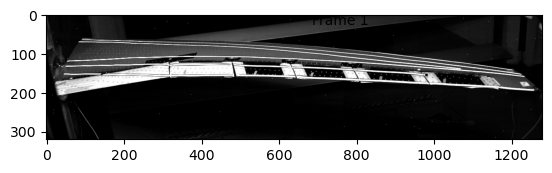

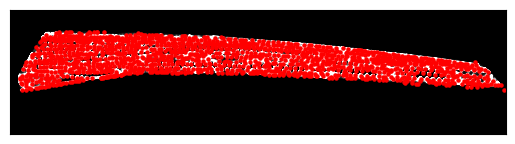

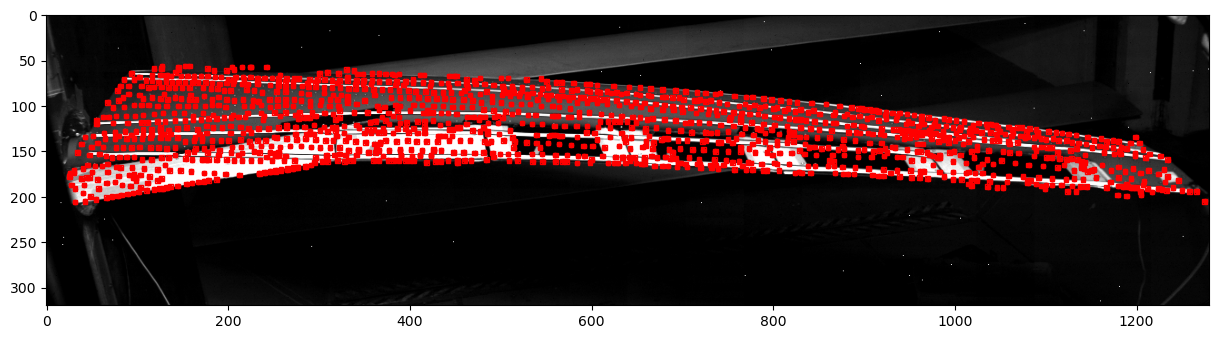

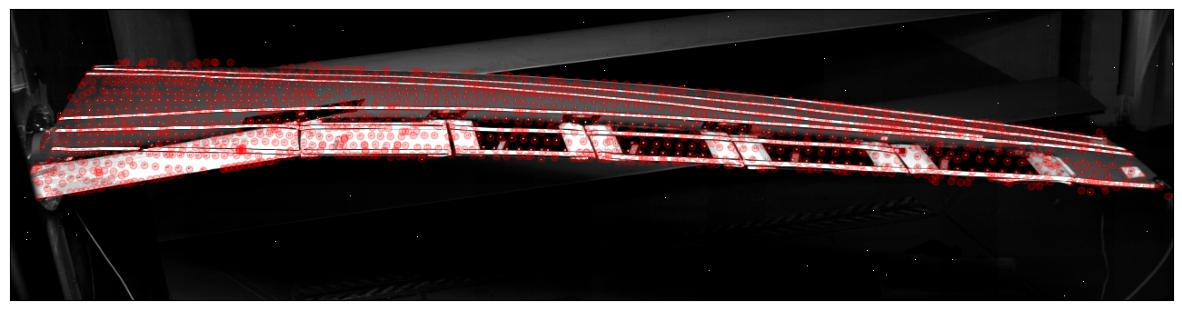

In [50]:
%matplotlib inline
roi_size = (5,5)
reference_image = (0, 40)
n_tracking_points = 2000
mean_image      = np.mean(video.mraw[reference_image[0]:reference_image[1]], axis=0)
# mean_image[mean_image > 2**video.info['EffectiveBit Depth']-20] = np.nan


path = Path(polygon.T)
mask_image = path.contains_points(np.array([(i,j) for i in range(mean_image.shape[0]) for j in range(mean_image.shape[1])])).reshape(mean_image.shape)
mask_image = mask_image.reshape(mean_image.shape)

# mask_image = path.contains_points(np.array([(i,j) for i in range(mean_image.shape[0]) for j in range(mean_image.shape[1])]))
# mask_image = mask_image.reshape(mean_image.shape)

feature_selecter = FeatureSelecter(mean_image)
feature_selecter.set_filter_method('eig0', roi_size)
score_full = feature_selecter.apply_filter(downsample=1)
score_full[~mask_image] = 0
maxima2d = feature_selecter.pick_max_filter(score_image = score_full, min_distance = roi_size, absolute_treshold = 0.0, top_n_points = n_tracking_points) #, top_n_points = n_tracking_points
feature_selecter.plot_score_image(maxima=True, umin=0, umax=50000)


video.set_method('lk')
video.method.configure(roi_size = roi_size, reference_image = reference_image, resume_analysis=False) #, mraw_range=(1, 1000)
mask_points = path.contains_points(maxima2d)
video.set_points(maxima2d[mask_points])
video.show_points()

fig, ax = plt.subplots(figsize=(15,10))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(mean_image, cmap='gray')
ax.plot(maxima2d[mask_points][:,1], maxima2d[mask_points][:,0], 'ro', markersize=5, alpha=0.2)

In [ ]:
displacement = video.get_displacements(processes = 24)
EMA_structure.displacements = displacement
EMA_structure.maxima = maxima2d[mask_points]
EMA_structure.mean_image = mean_image
root = 'C:/Users/thijsmas/Documents/GitHub/pyidi_data/'
path = os.path.join(root, 'EMA structure', file_name+f'_2d_roi{roi_size[0]}x{roi_size[1]}.pkl')
with open(path, 'wb') as f:
    pk.dump(EMA_structure, f)

In [ ]:
%matplotlib qt
td     = displacement +  maxima2d[mask_points].reshape(len(maxima2d[mask_points]),1,2)
ani = play_video(video, range(1000, video.N-1), interval=30, points=td, axis=([0, video.info['Image Width']],[video.info['Image Height'], 0]))

## Set points 1D

In [51]:
%matplotlib qt
roi_size = (11,11)
n_tracking_points = 3200
Gi, Gj = np.gradient(mean_image)
# s = np.array([0,1])
dyx = (1, 0)
Gs  = np.abs(dyx[0]*Gi + dyx[1]*Gj)
filtered_image = uniform_filter(Gs, size=roi_size[0])

mask_image = path.contains_points(np.array([(i,j) for i in range(mean_image.shape[0]) for j in range(mean_image.shape[1])])).reshape(mean_image.shape)
mask_image = mask_image.reshape(mean_image.shape)

filtered_image[~mask_image] = 0
# filtered_image[mean_image >= int(0.99*(2**bit_depth-1))] = 0

# maxima1d = feature_selecter.pick_max_filter(score_image = filtered_image, min_distance = roi_size[0], absolute_treshold = None, threshold_percentage = 0, top_n_points = n_tracking_points)
maxima1d = feature_selecter.pick_max_loop(score_image = filtered_image, min_distance = (5,5), n_points = n_tracking_points, minimum_score= 10)
fig, ax = plt.subplots()
ax.set_xticks([])
ax.set_yticks([])
# mask_points = path.contains_points(maxima1d)

ax.imshow(filtered_image, cmap='gray')
# ax.scatter(maxima1d[:, 1], maxima1d[:, 0], s=5, c='r')
plt.show()

video.set_method('lk_1D')

video.method.configure(roi_size = roi_size, dyx = dyx, reference_image = reference_image, resume_analysis=False) #, mraw_range=(1, 1000)
video.set_points(maxima1d)
video.show_points()
maxima1d.shape

(3200, 2)

In [52]:
displacement_1d = video.get_displacements(processes=12)
# EMA_structure.displacements = displacement
# EMA_structure.maxima = maxima1d
# EMA_structure.mean_image = mean_image
# root = 'C:/Users/thijsmas/Documents/GitHub/pyidi_data/'
# path = os.path.join(root, 'EMA structure', file_name+f'_1d_roi{roi_size[0]}x{roi_size[1]}.pkl')
# with open(path, 'wb') as f:
#     pk.dump(EMA_structure, f)

--- Starting new analysis ---
 
Computation start: 2024-05-17 14:49:56.528884


c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


VBox()

Computation duration: 00:24:58.70
D:/thijsmas\wing\mraw\1xyz_a_rev6_wcam_pyidi_analysis\analysis_005\ analysis_005


In [ ]:
roi_size_2d = (7,7)
roi_size_1d = (3,3)
reference_image = (0, 150)
n_tracking_points_1d = 6000
n_tracking_points_2D = 6000
Polygon = Path(polygon.T)
d = (0,1)
s = np.array([0,1])
root = 'C:/Users/thijsmas/Documents/GitHub/pyidi_data/'

for path_c in path_list:
    file_name = os.path.basename(path_c)
    EMA_structure = EMA_Structure(file_name[:-5] + '.cih')
    video = EMA_structure.open_video(add_extension=False)

    mean_image      = np.mean(video.mraw[reference_image[0]:reference_image[1]], axis=0)

    feature_selecter = FeatureSelecter(mean_image)
    feature_selecter.set_filter_method('eig0', roi_size_2d)
    score_full = feature_selecter.apply_filter(downsample=1)
    maxima2d = feature_selecter.pick_max_filter(score_image = score_full, min_distance = roi_size_2d, absolute_treshold = 0.0) #, top_n_points = n_tracking_points
    mask_points = Polygon.contains_points(maxima2d)

    video.set_method('lk')
    video.method.configure(roi_size = roi_size_2d, reference_image = reference_image, resume_analysis=False) #, mraw_range=(1, 1000)
    video.set_points(maxima2d[mask_points])

    displacement = video.get_displacements(processes = 24)
    EMA_structure.displacements = displacement
    EMA_structure.maxima = maxima2d[mask_points]
    EMA_structure.mean_image = mean_image
    
    path = os.path.join(root, 'EMA structure', file_name+f'_2d_roi{roi_size_2d[0]}x{roi_size_2d[1]}.pkl')
    with open(path, 'wb') as f:
        pk.dump(EMA_structure, f)
    
    Gi, Gj = np.gradient(mean_image)
    
    Gs  = s[0]*Gj + s[1]*Gi
    filtered_image = uniform_filter(Gs, size=roi_size_1d[0])
    maxima1d = feature_selecter.pick_max_filter(score_image = Gi, min_distance = roi_size_1d[0], absolute_treshold = None, threshold_percentage = 0, top_n_points = n_tracking_points)

    mask_points = Polygon.contains_points(maxima1d)
    video.set_method('lk_1D')
    video.method.configure(roi_size = roi_size_1d, d = d, reference_image = reference_image, resume_analysis=False) #, mraw_range=(1, 1000)
    video.set_points(maxima1d[mask_points])

    displacement = video.get_displacements(processes=24)
    EMA_structure.displacements = displacement
    EMA_structure.maxima = maxima1d[mask_points]
    EMA_structure.mean_image = mean_image

    path = os.path.join(root, 'EMA structure', file_name+f'_1d_roi{roi_size_1d[0]}x{roi_size_1d[1]}.pkl')
    with open(path, 'wb') as f:
        pk.dump(EMA_structure, f)
